In [3]:
import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline

# data cache config
lk_download_dir = '../data'
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir
    lk.search.sr_cache.expire_seconds = 86400

# make markdown table aligned to the left of the cell output (instead of center)
display(HTML("<style>table {margin-left: 4ch;}</style>"))

<IPython.core.display.Javascript object>

In [22]:
import sys
if "../eb_with_diff_sb_period/etv/" not in sys.path:  # for etvp
    sys.path.append("../eb_with_diff_sb_period/etv/")

import etv_functions_with_period as etvp
import etv_functions

from types import SimpleNamespace  # to adapt LightCurve object to the structure exepcted by etv_functions

# TIC 99654378, potential mult-planet system with TTVs

In [10]:
tic = 99654378

sr = lk.search_lightcurve(f"TIC{tic}", )  # author="SPOC", cadence="short"
sr = sr[np.isin(sr.author, ["SPOC", "TESS-SPOC", "QLP"])]  # to remove DIMANTE lc
sr = lke.filter_by_priority(sr, author_priority = ["SPOC", "TESS-SPOC", "QLP"])

astropy.table.pprint.conf.max_lines = 100  # to print all rows
display(sr)

lcc_tess = sr.download_all()
lcc_tess

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 26,2020,TESS-SPOC,1800,99654378,0.0,N/A
1,TESS Sector 40,2021,TESS-SPOC,600,99654378,0.0,N/A
2,TESS Sector 47,2021,TESS-SPOC,600,99654378,0.0,N/A
3,TESS Sector 53,2022,TESS-SPOC,600,99654378,0.0,N/A
4,TESS Sector 60,2022,SPOC,120,99654378,0.0,N/A
5,TESS Sector 74,2024,SPOC,120,99654378,0.0,N/A


LightCurveCollection of 6 objects:
    0: <TessLightCurve LABEL="TIC 99654378" SECTOR=26 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 99654378" SECTOR=40 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 99654378" SECTOR=47 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 99654378" SECTOR=53 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="TIC 99654378" SECTOR=60 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    5: <TessLightCurve LABEL="TIC 99654378" SECTOR=74 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

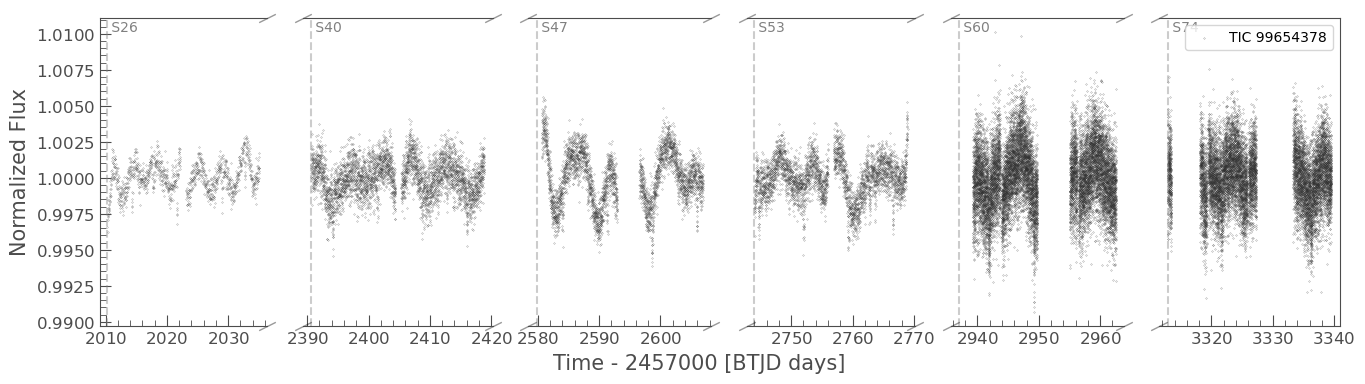

In [12]:
lc = lke.stitch(lcc_tess, corrector_func=lambda lc: lc.normalize())
axs = tplt.plot_skip_data_gap(lc, s=0.1);

In [6]:
# The initial tranist parameters 
transit_specs = TransitTimeSpecList(  # TIC 99654378, TOI .01 and possibly more
    dict(epoch=2598.6553460, duration_hr=3.3584932, period=7.3034530 , label="pl 1", transit_depth_percent=0.1563,  # Pyaneti fit from TESS-SPOC 10min sectors
        # epoch=2598.6592, duration_hr=3.2180, period=7.303959, label="TOI 5182.01", transit_depth_percent=0.2050,  # TOI value
         sector=47, steps_to_show=[0,  1],  # -1,  -2
        ),
    dict(epoch=2018.0336720, period=14.6207858, duration_hr=5.237, label="pl 2", transit_depth_percent=0.1064,  # Pyaneti fit from TESS-SPOC 10min sectors (duration_hr from zoo3hans)
         # epoch=(2017.928620+2018.146814)/2, period=14.6207, duration_hr=5.237, label="pl 2", transit_depth_percent=0.1272,  # from zoo3hans
         sector=26, steps_to_show=[1,  0],  # step 0 close to pl 3
    ),
    dict(epoch=(2017.611356+2017.903022)/2, period=745.037949, duration_hr=7.0, label="pl 3", transit_depth_percent=0.2220,
         sector=26, steps_to_show=[0],
         # sector=53, steps_to_show=[1],  # step 1 in S53
    ),
    dict(epoch=(3320.920022+3321.107522)/2, period=9999.9, duration_hr=4.5, label="pl 4", transit_depth_percent=0.2035,
         sector=74, steps_to_show=[0],
    ),
    defaults=dict(surround_time=0.5)
)


## TTV for `pl 2`

In [74]:
lcc_tess = lke.select(lcc_tess, lambda lc: lc.sector != 60)   # sector 60 has no dip for pl2
lcc_tess

LightCurveCollection of 5 objects:
    0: <TessLightCurve LABEL="TIC 99654378" SECTOR=26 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 99654378" SECTOR=40 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 99654378" SECTOR=47 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 99654378" SECTOR=53 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="TIC 99654378" SECTOR=74 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

5


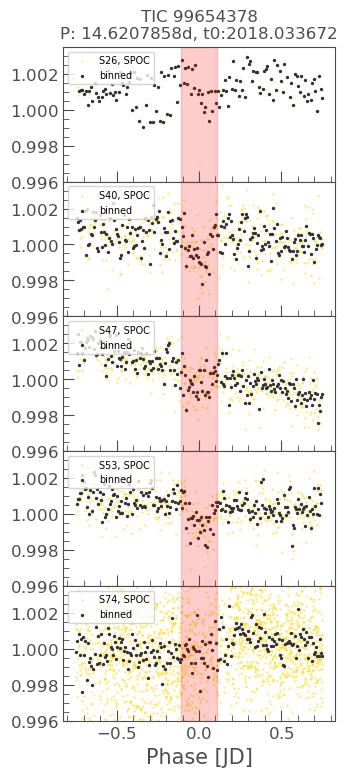

In [100]:
# The period from Pyaneti seems to be solid except TTV, so I use it as-is
a_spec = transit_specs[1]

# fold each sector's data, and attempt to find the best-fit t0 in each sector
lc_f_c = []
for lc in lcc_tess:
    # lc_f = lc.select_flux("sap_flux").normalize().truncate(0.99, 1.01, column="flux").fold(  # S74 dips looks clearer in SAP_FLUX
    lc_f = lc.normalize().fold(
        period=a_spec['period'], epoch_time=a_spec['epoch'],
        # period=14.6207, epoch_time=(2017.928620+2018.146814)/2,   # from zoo3hans
    )
    lc_f.label = f"S{lc_f.sector}, {lc_f.author}"
    lc_f_c.append(lc_f)
print(len(lc_f_c))


with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(len(lc_f_c), 1, sharex=True, squeeze=True, figsize=(3.5, 1.75 * len(lc_f_c)));
    fig.subplots_adjust(wspace=0, hspace=0)

for i, lc_f  in enumerate(of_sectors(lc_f_c[:],)):
    ax = axs[i]
    
    # lc_f = lc_f.truncate(0 - a_spec['duration_hr'] / 24 * 1.5, 0 + a_spec['duration_hr'] / 24 * 1.5)
    lc_f = lc_f.truncate(-0.75, 0.75)  # use a larger window so that S74 dip is more apparent
    ax = lc_f.scatter(ax=ax, s=0.5, c="gold")

    lc_f_b = lke.bin_flux(lc_f, time_bin_size=10*u.min)
    ax = lc_f_b.scatter(ax=ax, s=2, marker="o", label="binned")

    ax.legend(loc="upper left", fontsize="x-small");
    ax.axvspan(0 - a_spec['duration_hr'] / 24 * 0.5, 0 + a_spec['duration_hr'] / 24 * 0.5, color="red", alpha=0.2);

    ax.set_ylim(0.996, 1.0035)  # consistent y-scale
    
    if lc_f is not lc_f_c[-1]:
        ax.set_ylabel(None)
axs[0].set_title(f"{lcc_tess[0].label}\nP: {a_spec['period']}d, t0:{a_spec['epoch']}");

In [67]:
# Guess MCMC initial values, using S40, 47, 53 (relatively close)

lc_f = lke.stitch(of_sectors(lcc_tess, 40, 47, 53)).fold(period=a_spec['period'], epoch_time=a_spec['epoch'])
lc_f = lc_f.truncate(0 - a_spec['duration_hr'] / 24 * 0.9, 0 + a_spec['duration_hr'] / 24 * 0.9)
print("len(lc_f):", len(lc_f))
# lc_f.scatter();

lc_f_b = lc_f.bin(time_bin_size=5*u.min)
# ax2 = lc_f_b.scatter(ax=ax2, label="binned")
print("len(lc_f_b):", len(lc_f_b))

# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
start_vals = [1.0, -0.003, 0.0, 0.04, 5.0]

# convert lc to the form needed by fit etv_functions
lc_f_data = SimpleNamespace(time=lc_f.time_original.value, phase=lc_f.time.value, flux=np.array(lc_f.flux.value), err=np.array(lc_f.flux_err.value))
etv_functions.plot_initial_guess_interactive(lc_f_data, lc_f_b.time.value, lc_f_b.flux.value, lc_f_b.flux_err.value, "t0_phase_pl1", *start_vals)
# etv_functions.plot_initial_guess_interactive(lc_f_data, None, None, None, "t0_phase_pl1", *start_vals)

len(lc_f): 339
len(lc_f_b): 113


Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

100%|█████████████████████████████████████████████████████████| 2000/2000 [00:16<00:00, 119.83it/s]


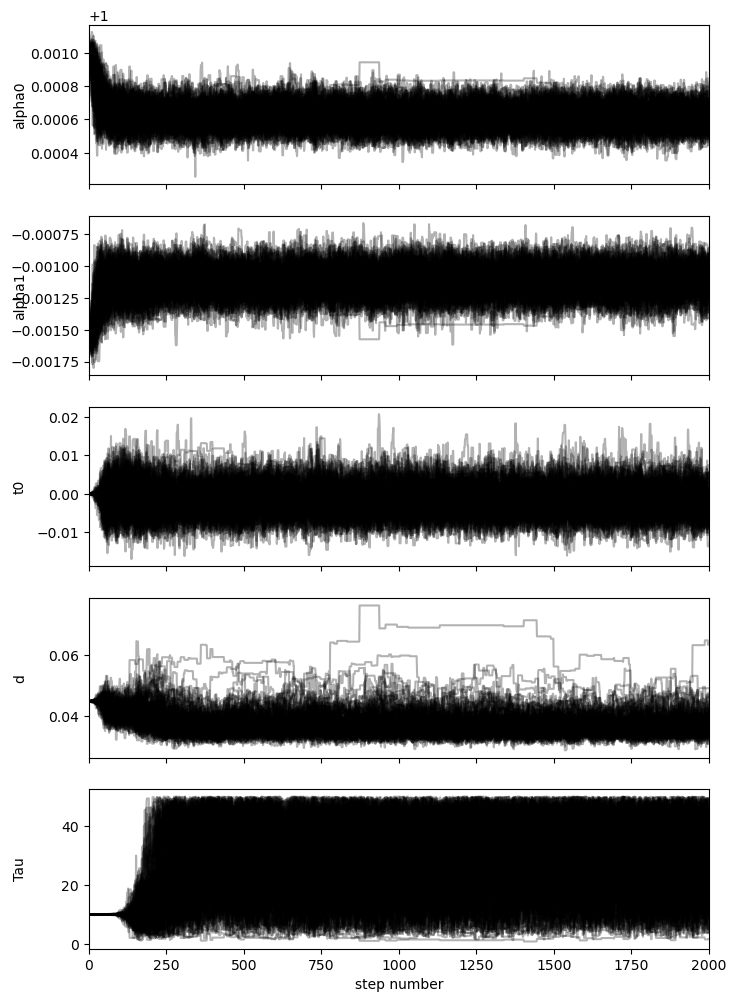

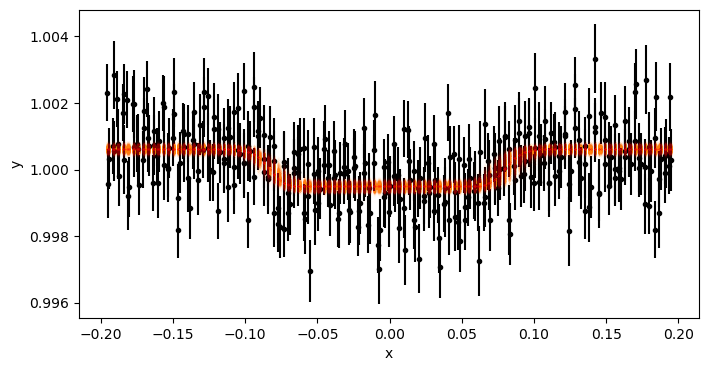

mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau= 1.000618964219428, -0.0011200620227242164, -0.0018379533484571679, 0.036545664333877945, 30.093633203552372
std_values: {'std_alpha0': 7.066609167362288e-05, 'std_alpha1': 0.0001095659980723652, 'std_t0': 0.003801082818619195, 'std_d': 0.0035909074384165023, 'std_Tau': 13.062397837692636}


In [69]:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, fit_params_stats  = etv_functions.run_mcmc_initial_fit(
    lc_f_data, 
    [1.001, -0.0015, 0.0, 0.045, 10.0],
    nruns=2000, discard=1500,
    # nruns=1000, discard=600,
    # nruns=20, discard=1,
    pool=-2, 
    plot_chains=True, plot=True, 
    also_return_stats=True,
)

# mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau= 1.000618964219428, -0.0011200620227242164, -0.0018379533484571679, 0.036545664333877945, 30.093633203552372
print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau= " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
print("std_values:", fit_params_stats)


100%|█████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 390.31it/s]


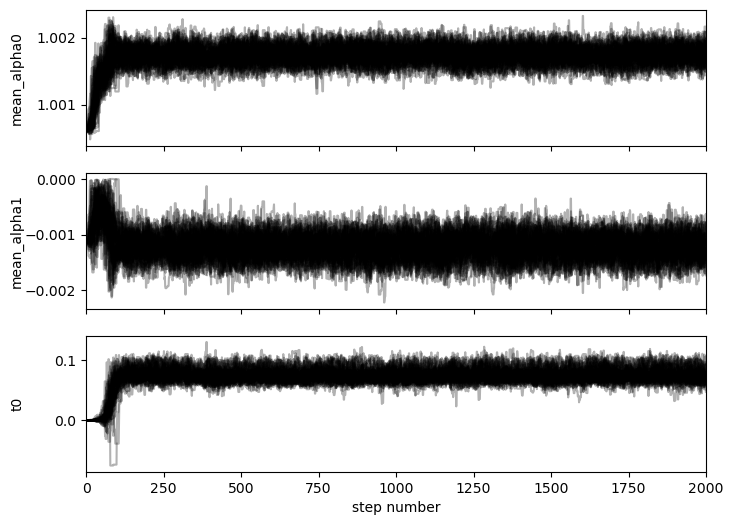

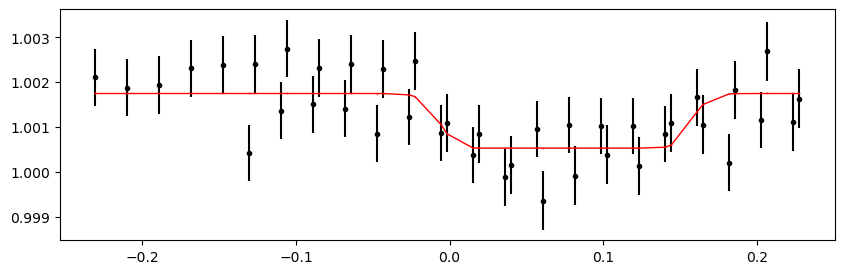

[26, 1.0017485089187188, -0.0012161849934448454, 0.07498242488149472, 0.01053026253789588]


100%|█████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 344.11it/s]


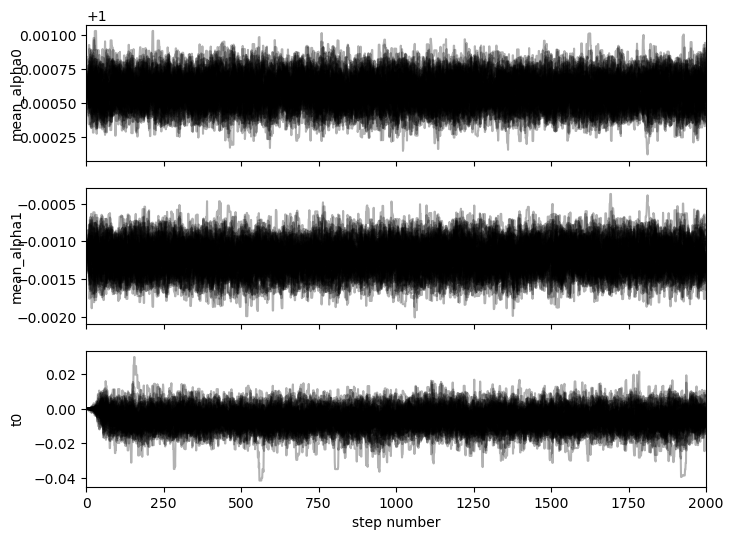

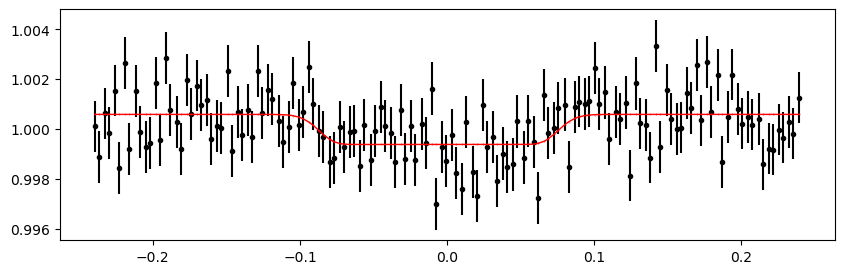

[40, 1.0005907418287932, -0.00120478470805897, -0.0056807404267782725, 0.005761514874548341]


100%|█████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 345.21it/s]


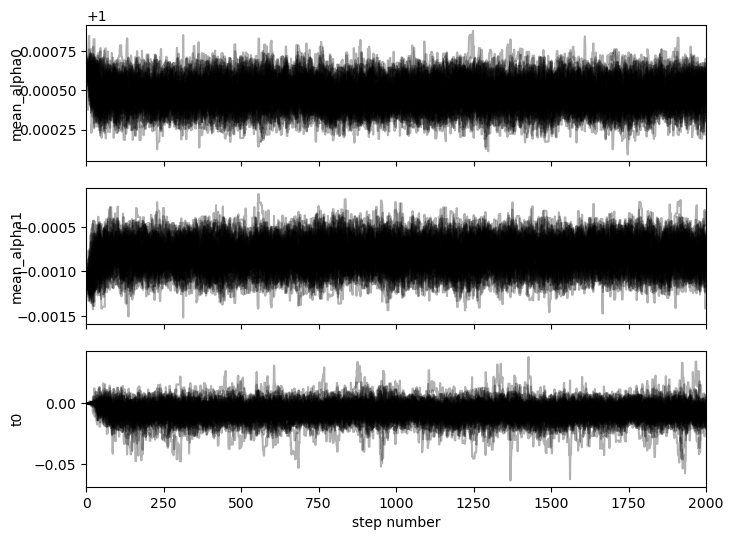

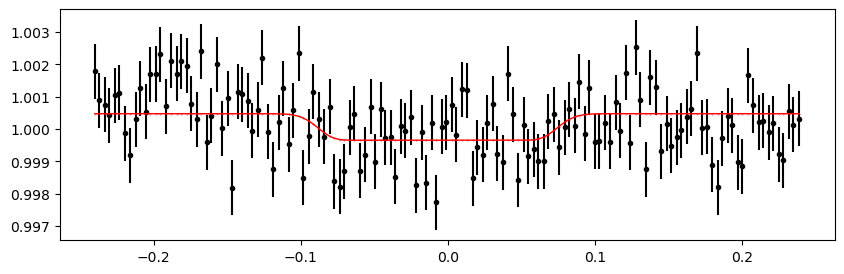

[47, 1.0004761569280816, -0.0008219416408101023, -0.00683435986200335, 0.0068226276681672806]


100%|█████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 346.15it/s]


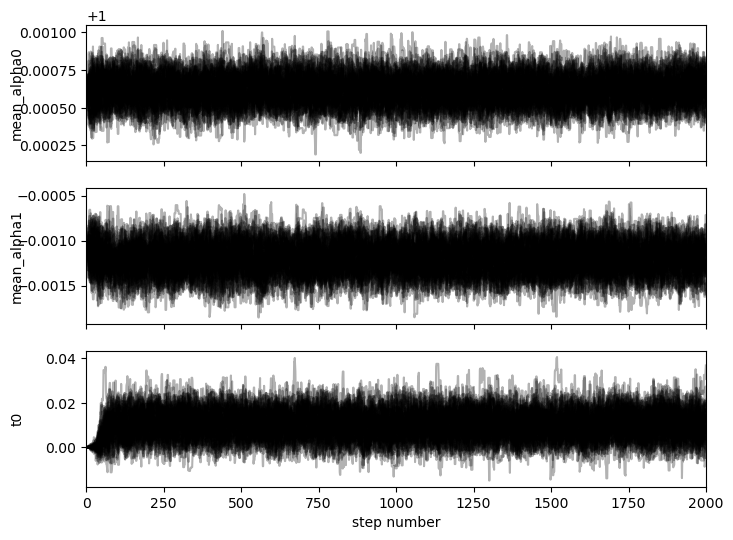

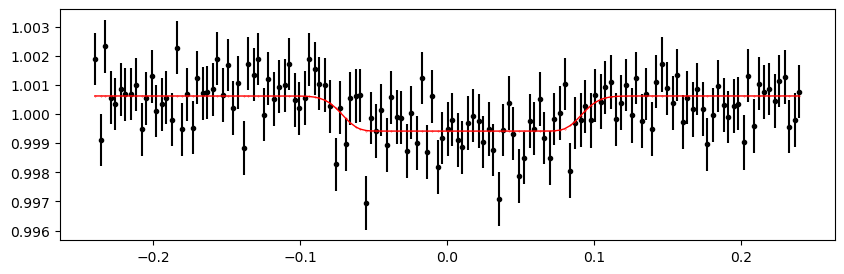

[53, 1.0006183529371242, -0.0012048729558699622, 0.009948675100655328, 0.006238941686440605]


100%|█████████████████████████████████████████████████████████| 5000/5000 [00:25<00:00, 194.98it/s]


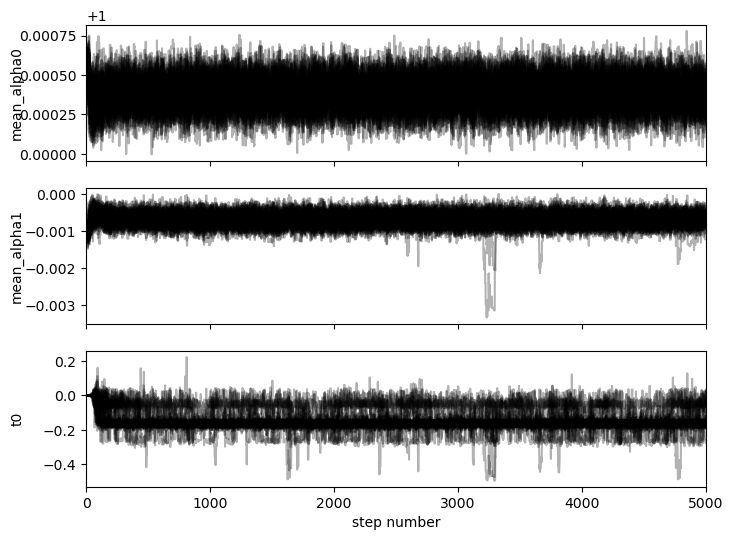

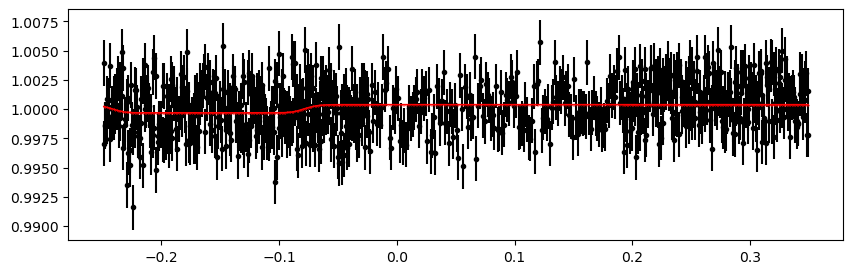

[74, 1.000387662880397, -0.0006944090470629523, -0.16035581849153574, 0.04440143861953001]


In [113]:
fitted_params_list = []

for lc in lcc_tess[:]:
    sector = lc.sector
    lc = lc.remove_nans().normalize()
    pl3_transit_mask = (2017.55 < lc.time.value) & (lc.time.value < 2017.90)  # the pl3 dip is immediately followed by dip of pl2 , mask the pl3 dip to avoid confusion
    lc = lc[~pl3_transit_mask]
    lc_f = lc.fold(period=a_spec['period'], epoch_time=a_spec['epoch'])
    
    nruns, discard = 2000, 1000  # default MCMC params
    if sector == 74: 
        lc_f = lc_f.truncate(-0.25, 0.35)  # a larger window due to apparent t0 shfit and noisy data
        nruns, discard = 5000, 4000  # let it run longer to get the params converged
    # elif sector == 26: 
        # lc_f = lc_f.truncate(-0.08, 0.22)   # accomodate the shift
    else:  # default
        # lc_f = lc_f.truncate(-0.15, 0.15)  # generally fit S40, 47, 53
        # larger truncated window to accomodate shift in t0, also it looks like the MCMC fit requirs the extra out-of-transit data to get the params converged
        lc_f = lc_f.truncate(0 - a_spec['duration_hr'] / 24 * 1.1, 0 + a_spec['duration_hr'] / 24 * 1.1)
        

    # convert lc to the form needed by fit etv_functions
    lc_f_data = SimpleNamespace(time=lc_f.time_original.value, phase=lc_f.time.value, flux=np.array(lc_f.flux.value), err=np.array(lc_f.flux_err.value))

    fitted_params = etv_functions.run_mcmc_individual_fit(
        lc_f_data, 
        # use fixed d, Tau, and fit alpha0, alpha1, t0
        [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau],  
        nruns=nruns, discard=discard,
        # nruns=20, discard=1,
        pool=None, # parallel not helpful with limited data per lc_f
        plot_chains=True,
        plot=True, 
    )
    # [alpha0, alpha1, t0, stdv_t0] =  fitted_params
    fitted_params = [sector] + fitted_params  # include sector as a proxy of epoch
    fitted_params_list.append(fitted_params)
    print(fitted_params)

,sector,alpha0,alpha1,t0,stdv_t0,t0_min,stdv_t0_min
0,26,1.001749,-0.001216,0.074982,0.010530,107.974692,15.163578
1,40,1.000591,-0.001205,-0.005681,0.005762,-8.180266,8.296581
2,47,1.000476,-0.000822,-0.006834,0.006823,-9.841478,9.824584
3,53,1.000618,-0.001205,0.009949,0.006239,14.326092,8.984076
4,74,1.000388,-0.000694,-0.160356,0.044401,-230.912379,63.938072


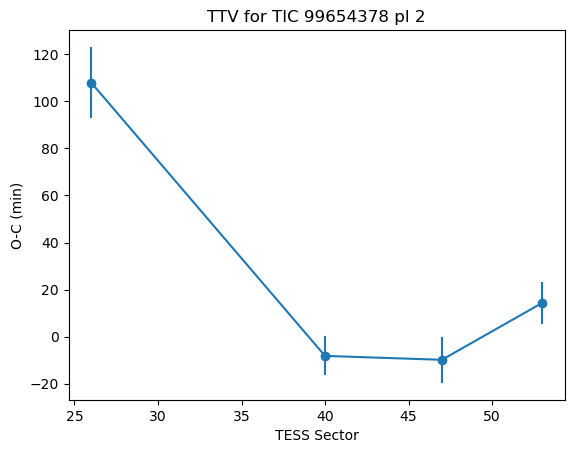

In [115]:
import pandas as pd

c_sector, c_alpha0, c_alpha1, c_t0, c_stdv_t0 = [], [], [], [], []

for fitted_params in fitted_params_list:
    sector, alpha0, alpha1, t0, stdv_t0 = fitted_params
    c_sector.append(sector), c_alpha0.append(alpha0), c_alpha1.append(alpha1), c_t0.append(t0), c_stdv_t0.append(stdv_t0)

df_fitted_params = pd.DataFrame(dict(sector=c_sector, alpha0=c_alpha0, alpha1=c_alpha1, t0=c_t0, stdv_t0= c_stdv_t0))

df_fitted_params["t0_min"] = df_fitted_params.t0 * 24 * 60
df_fitted_params["stdv_t0_min"] = df_fitted_params.stdv_t0 * 24 * 60

display(df_fitted_params)

df_fitted_params_unfiltered = df_fitted_params

df_fitted_params = df_fitted_params[df_fitted_params.sector != 74]  # avoid S74 with huge error

ax = plt.figure().gca()
ax.errorbar(x=df_fitted_params.sector, y=df_fitted_params.t0_min, yerr=df_fitted_params.stdv_t0_min, marker="o");
ax.set_xlabel("TESS Sector");
ax.set_ylabel("O-C (min)");
ax.set_title(f"""TTV for TIC {tic} {a_spec["label"]}""");